# Retroperitoneal sarcoma radiomics study
# Prediction of tumour type and grade
# Logistic regression with group selection

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_rows', 500, 'display.precision', 3)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate
import os, warnings, copy, sys, shutil
import matplotlib.pyplot as plt
import dill
import pickle
from time import strftime, localtime
from pyirr import intraclass_correlation
from scipy.stats import skew

rootFolder = os.path.join(os.path.expanduser("~"), 'Dicom Files/RADSARC_R')

# this module should be in the same folder as this notebook
from fit_LR_groupSelection_correlationThresholds import fit_LR_groupSelection_correlationThresholds, plotResultExperiments, displayOneExperiment

n_splits = 10
n_repeats = 50
thresholds = np.round(np.arange(0.6,1.00001,0.01), 2)
penalty = 'l1'

### Utility functions

In [2]:
def groupStrsDisp(strGroups):
    
    def tidyGroup(strGroup):
        if strGroup == '':
            strGroup = 'all'
        strGroup = strGroup.replace('glcm|gldm|glszm|glrlm|ngtdm','texture')
        strGroup = strGroup.replace('firstorder|histogram','firstorder')
        return strGroup

    if isinstance(strGroups, str):
        return tidyGroup(strGroups)
    
    if isinstance(strGroups, list):
        return [tidyGroup(x) for x in strGroups]

## Load data

In [3]:
# open clinical spreadsheet
clinicalSpreadsheet = os.path.join(rootFolder, 'ClinicalData', 'Clinical data for analysis.xlsx')
dfClinical = pd.read_excel(clinicalSpreadsheet, sheet_name='220818_Completed segs', engine='openpyxl')
dfClinical = dfClinical[['Anon Code', 'Grade', 'subtype']]

In [4]:
# open radiomics data
dfRad = pd.read_csv(os.path.join(rootFolder, 'XNAT/extractions/extractions__20221109_2030_allRegions/radiomicFeatures/radiomicFeatures.csv'))
dfRad.drop(list(dfRad.filter(regex = 'source')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'diagnostic')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'histogram')), axis = 1, inplace = True)

# open reproducibility data
dfRadRep = pd.read_csv(os.path.join(rootFolder, 'XNAT/extractions/extractions__20221109_1137_repro/radiomicFeatures/radiomicFeatures.csv'))
dfRadRep.drop(list(dfRadRep.filter(regex = 'source')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'diagnostic')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'histogram')), axis = 1, inplace = True)

## Compute ICCs and remove unreproducible features

In [5]:
dfRadOri = dfRad.copy()

subjectIDs = dfRadOri.merge(dfRadRep, on='StudyPatientName').StudyPatientName

# select rows and make sure they are both sorted on SubjectID
dfRadOri = dfRadOri.loc[dfRadOri['StudyPatientName'].isin(subjectIDs)]
dfRadOri.sort_values('StudyPatientName', axis=0, inplace=True)

dfRadRep = dfRadRep.loc[dfRadRep['StudyPatientName'].isin(subjectIDs)]
dfRadRep.sort_values('StudyPatientName', axis=0, inplace=True)

# remove high/mid/low_enhancing features
dfRadOri.drop(list(dfRadOri.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)

# remove these features
dfRadOri.drop(list(dfRadOri.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)

dfRadOri.reset_index(inplace=True)
dfRadRep.reset_index(inplace=True)

iccValues = []
featNames = []
for col in dfRadOri.columns:
    if col == 'StudyPatientName' or col=='index':
        continue
    data = np.stack((dfRadOri[col], dfRadRep[col]), axis=1)
    featNames.append(col)
    iccValues.append(intraclass_correlation(data, "twoway", "agreement").value)
iccDf = pd.DataFrame({'Feature':featNames, 'ICC':iccValues})

iccThreshold = 0.75

reproducibleFeatures = list(iccDf.Feature[iccDf.ICC>iccThreshold])
reproducibleFeatures.append('StudyPatientName')

dfRad = dfRad.filter(reproducibleFeatures)

dfRad.shape

(170, 90)

## Log transform positive skewed parameters

In [6]:
for feat in dfRad.filter(regex='lesion_original', axis=1).columns:
    if skew(dfRad[feat])>3 and np.all(dfRad[feat]>0):
        dfRad[feat+'_log'] = np.log(dfRad[feat])
        dfRad.drop(feat, axis=1, inplace=True)

# this is heavily skewed, but has minimum value -87
dfRad['lesion_original_glcm_ClusterShade_log'] = np.log(dfRad['lesion_original_glcm_ClusterShade']+90)
dfRad.drop('lesion_original_glcm_ClusterShade', axis=1, inplace=True)

## Create output and copy code

In [7]:
%%capture out_stream

# set output folder to None if this is a fresh run
# set output folder to an existing location to load pre-saved results from there
outputFolder = None #'/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/LR_GroupSelection__20220924_0958'

if outputFolder is None:
    
    saveOutputs = True
    
    outputFolder = os.path.join(rootFolder, 'XNAT/experiments/LR_GroupSelection__' + strftime("%Y%m%d_%H%M", localtime()))
    os.mkdir(outputFolder)
    os.mkdir(os.path.join(outputFolder, 'code'))

    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection.ipynb'))

    file = os.path.join(os.path.abspath(""), 'fit_LR_groupSelection_correlationThresholds.py')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'fit_LR_groupSelection_correlationThresholds.py'))

    user = os.path.expanduser("~")
    file = os.path.join(user, 'Documents/git/git_icrpythonradiomics/machineLearning/featureSelection.py')
    shutil.copyfile(file, os.path.join(outputFolder, 'code', 'featureSelection.py'))

else:
    
    saveOutputs = False

## Run classifications

### Tumour type: LMS v.s LPS
### Standard radiomics features

In [8]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'subtype'
featureSet = 'lesion_original'

df = df.filter(regex=featureSet + '|' + target)

In [9]:
# with open('/Users/morton/Documents/git/git_radsarc/classification/debugVariables.pickle', 'wb') as handle:
#     pickle.dump({'df':df, 'target':target, 'settings':settings}, handle)

In [10]:
settings = {'n_splits':n_splits, 
            'n_repeats':n_repeats,
            'thresholds':thresholds,
            'penalty':penalty
           }

textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
settings['groupHierarchy'] = ['shape',
                              'firstorder',
                              textureStr,
                              'shape|firstorder',
                              'shape|' + textureStr,
                              'firstorder|' + textureStr,
                              '']

quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_Standard_TumourType.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

    if saveOutputs:
        with open(quickLoadFile, 'wb') as handle:
            pickle.dump(result, handle)
    
resultStandardType = copy.deepcopy(result)

del result
    

Threshold = 0.6
firstorder|texture
AUROC = 0.872 ± 0.0984

Threshold = 0.61
firstorder|texture
AUROC = 0.886 ± 0.092

Threshold = 0.62
firstorder|texture
AUROC = 0.893 ± 0.0885

Threshold = 0.63
firstorder|texture
AUROC = 0.898 ± 0.084

Threshold = 0.64
firstorder|texture
AUROC = 0.9 ± 0.0836

Threshold = 0.65
firstorder|texture
AUROC = 0.902 ± 0.0829

Threshold = 0.66
firstorder|texture
AUROC = 0.902 ± 0.0825

Threshold = 0.67
firstorder|texture
AUROC = 0.902 ± 0.0818

Threshold = 0.68
firstorder|texture
AUROC = 0.902 ± 0.0814

Threshold = 0.69
firstorder|texture
AUROC = 0.902 ± 0.0814

Threshold = 0.7
firstorder|texture
AUROC = 0.902 ± 0.0811

Threshold = 0.71
firstorder|texture
AUROC = 0.902 ± 0.0797

Threshold = 0.72
firstorder|texture
AUROC = 0.901 ± 0.0796

Threshold = 0.73
firstorder|texture
AUROC = 0.902 ± 0.0795

Threshold = 0.74
firstorder|texture
AUROC = 0.901 ± 0.0794

Threshold = 0.75
firstorder|texture
AUROC = 0.901 ± 0.0794

Threshold = 0.76
firstorder|texture
AUROC = 0.

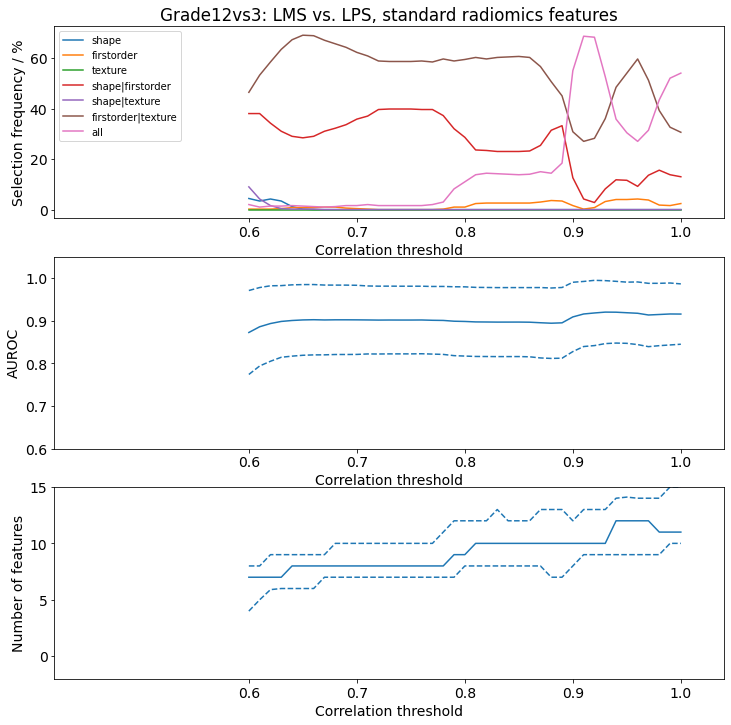

AUROC (CV) = 0.91986

Feature group = firstorder|texture



Feature,Frequency,Coef
lesion_original_firstorder_Skewness,99.000,-0.350
lesion_original_firstorder_RootMeanSquared,89.000,-0.422
lesion_original_glcm_ClusterProminence_log,84.200,1.327
lesion_original_gldm_SmallDependenceLowGrayLevelEmphasis,81.800,-1.038
lesion_original_glszm_SmallAreaEmphasis,76.400,0.295
lesion_original_glszm_ZonePercentage,68.200,0.333
lesion_original_glcm_Idmn,66.800,1.015
lesion_original_firstorder_Mean,65.000,-2.877
lesion_original_ngtdm_Strength_log,63.400,-0.469
lesion_original_shape_Elongation,47.600,


In [28]:
plotResultExperiments(resultStandardType, titleStr=target + ': LMS vs. LPS, standard radiomics features')

bestCoef, pdFreq = displayOneExperiment(resultStandardType, threshold=0.94)
display(pdFreq.style.hide_index())

### Tumour type: LMS v.s LPS
### Volume fraction and standard radiomics features

In [12]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'subtype'
featureSet = 'lesion_original|sarcomaFeature'

df = df.filter(regex=featureSet + '|' + target)

# remove one of the volume fraction features as it is co-linear with the others
df.drop('lesion_sarcomaFeature_mid enhancingVolumeFraction', axis=1, inplace=True)

In [13]:
settings = {'n_splits':n_splits, 
            'n_repeats':n_repeats,
            'thresholds':thresholds,
            'penalty':penalty
           }

quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_VolumeFractions_TumourType.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

    if saveOutputs:
        with open(quickLoadFile, 'wb') as handle:
            pickle.dump(result, handle)

resultVolFracType = copy.deepcopy(result)

del result
    

Threshold = 0.6
VolumeFraction|shape
AUROC = 0.868 ± 0.0918

Threshold = 0.61
VolumeFraction|shape
AUROC = 0.867 ± 0.0932

Threshold = 0.62
VolumeFraction|shape
AUROC = 0.867 ± 0.0925

Threshold = 0.63
VolumeFraction|shape
AUROC = 0.867 ± 0.092

Threshold = 0.64
VolumeFraction|shape
AUROC = 0.866 ± 0.0923

Threshold = 0.65
VolumeFraction|shape
AUROC = 0.867 ± 0.0914

Threshold = 0.66
VolumeFraction|shape
AUROC = 0.869 ± 0.0905

Threshold = 0.67
VolumeFraction|shape
AUROC = 0.87 ± 0.0908

Threshold = 0.68
VolumeFraction|shape
AUROC = 0.873 ± 0.0881

Threshold = 0.69
VolumeFraction|shape
AUROC = 0.874 ± 0.0872

Threshold = 0.7
VolumeFraction|shape
AUROC = 0.875 ± 0.0878

Threshold = 0.71
VolumeFraction|shape
AUROC = 0.875 ± 0.0875

Threshold = 0.72
VolumeFraction|shape
AUROC = 0.876 ± 0.0884

Threshold = 0.73
VolumeFraction|shape
AUROC = 0.877 ± 0.0877

Threshold = 0.74
firstorder|texture
AUROC = 0.878 ± 0.086

Threshold = 0.75
firstorder|texture
AUROC = 0.88 ± 0.0838

Threshold = 0.76
V

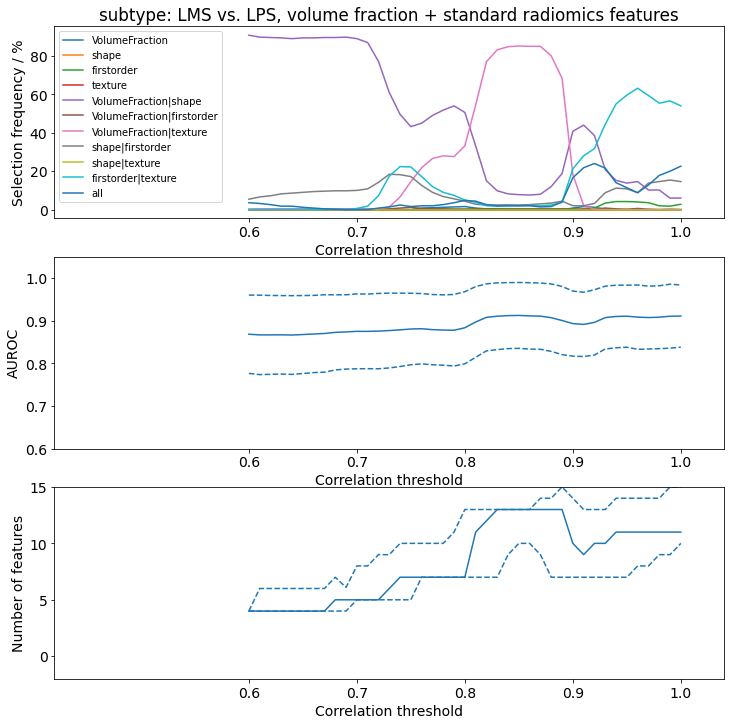

AUROC (CV) = 0.91228

Feature group = VolumeFraction|texture



Feature,Frequency,Coef
lesion_sarcomaFeature_high enhancingVolumeFraction,95.200,-0.668
lesion_sarcomaFeature_low enhancingVolumeFraction,95.200,7.548
lesion_original_glszm_SmallAreaEmphasis,89.200,0.540
lesion_original_gldm_SmallDependenceLowGrayLevelEmphasis,89.200,-4.830
lesion_original_glszm_ZonePercentage,87.800,2.044
lesion_original_glszm_ZoneEntropy,87.600,0.563
lesion_original_glszm_LargeAreaHighGrayLevelEmphasis_log,87.200,-4.108
lesion_original_ngtdm_Strength_log,86.400,0.442
lesion_original_glszm_ZoneVariance_log,85.400,5.096
lesion_original_ngtdm_Contrast,84.600,0.411


In [14]:
plotResultExperiments(resultVolFracType, titleStr = target + ': LMS vs. LPS, volume fraction + standard radiomics features')

bestCoef, pdFreq = displayOneExperiment(resultVolFracType, threshold=0.85)
pdFreq.style.hide_index()

### Tumour grade: 1 v.s 2 or 3
### Standard radiomics features

In [15]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'Grade1vs23'
featureSet = 'lesion_original'

df['Grade1vs23'] = df['Grade'] == 1

df = df.filter(regex=featureSet + '|' + target)

In [16]:
settings = {'n_splits':n_splits, 
            'n_repeats':n_repeats,
            'thresholds':thresholds,
            'penalty':penalty
           }

textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
settings['groupHierarchy'] = ['shape',
                              'firstorder',
                              textureStr,
                              'shape|firstorder',
                              'shape|' + textureStr,
                              'firstorder|' + textureStr,
                              '']

quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_Standard_Grade1vs23.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

    if saveOutputs:
        with open(quickLoadFile, 'wb') as handle:
            pickle.dump(result, handle)

resultStandardGrade_1vs23 = copy.deepcopy(result)

del result
    

Threshold = 0.6
firstorder|texture
AUROC = 0.81 ± 0.1647

Threshold = 0.61
firstorder|texture
AUROC = 0.827 ± 0.154

Threshold = 0.62
firstorder|texture
AUROC = 0.835 ± 0.1475

Threshold = 0.63
firstorder|texture
AUROC = 0.843 ± 0.144

Threshold = 0.64
firstorder|texture
AUROC = 0.85 ± 0.1349

Threshold = 0.65
firstorder|texture
AUROC = 0.851 ± 0.1351

Threshold = 0.66
firstorder|texture
AUROC = 0.853 ± 0.1336

Threshold = 0.67
firstorder|texture
AUROC = 0.857 ± 0.1313

Threshold = 0.68
firstorder|texture
AUROC = 0.859 ± 0.131

Threshold = 0.69
firstorder|texture
AUROC = 0.859 ± 0.1321

Threshold = 0.7
firstorder|texture
AUROC = 0.859 ± 0.1321

Threshold = 0.71
firstorder|texture
AUROC = 0.859 ± 0.1322

Threshold = 0.72
firstorder|texture
AUROC = 0.86 ± 0.1321

Threshold = 0.73
firstorder|texture
AUROC = 0.86 ± 0.1326

Threshold = 0.74
firstorder|texture
AUROC = 0.86 ± 0.1323

Threshold = 0.75
firstorder|texture
AUROC = 0.86 ± 0.1323

Threshold = 0.76
firstorder|texture
AUROC = 0.86 ± 

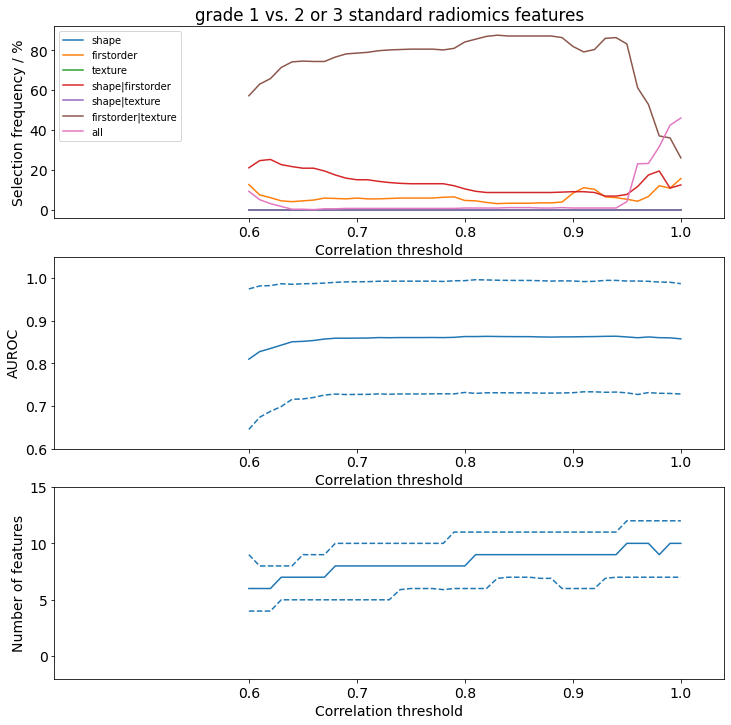

AUROC (CV) = 0.86276

Feature group = firstorder|texture



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,91.400,-1.766
lesion_original_firstorder_RootMeanSquared,90.800,0.132
lesion_original_gldm_DependenceNonUniformityNormalized_log,84.800,-0.411
lesion_original_ngtdm_Strength_log,79.600,0.288
lesion_original_glszm_ZonePercentage,68.200,0.191
lesion_original_firstorder_Skewness,67.800,0.048
lesion_original_firstorder_Kurtosis_log,56.400,0.066
lesion_original_glszm_LargeAreaHighGrayLevelEmphasis_log,48.400,-0.282
lesion_original_firstorder_InterquartileRange,47.200,
lesion_original_ngtdm_Contrast,38.000,


In [17]:
plotResultExperiments(resultStandardGrade_1vs23, titleStr = 'grade 1 vs. 2 or 3 standard radiomics features')

bestCoef, pdFreq = displayOneExperiment(resultStandardGrade_1vs23, threshold=0.8)
pdFreq.style.hide_index()

### Tumour grade: 1 or 2 v.s 3
### Standard radiomics features

In [18]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'Grade12vs3'
featureSet = 'lesion_original'

df[target] = df['Grade'] != 3

df = df.filter(regex=featureSet + '|' + target)

In [19]:
settings = {'n_splits':n_splits, 
            'n_repeats':n_repeats,
            'thresholds':thresholds,
            'penalty':penalty
           }

textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
settings['groupHierarchy'] = ['shape',
                              'firstorder',
                              textureStr,
                              'shape|firstorder',
                              'shape|' + textureStr,
                              'firstorder|' + textureStr,
                              '']

quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_Standard_Grade12vs3.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

    if saveOutputs:
        with open(quickLoadFile, 'wb') as handle:
            pickle.dump(result, handle)

resultStandardGrade_12vs3 = copy.deepcopy(result)

del result
    

Threshold = 0.6
firstorder
AUROC = 0.665 ± 0.1713

Threshold = 0.61
firstorder
AUROC = 0.689 ± 0.1607

Threshold = 0.62
firstorder
AUROC = 0.704 ± 0.1503

Threshold = 0.63
firstorder
AUROC = 0.722 ± 0.1354

Threshold = 0.64
firstorder
AUROC = 0.726 ± 0.1322

Threshold = 0.65
firstorder
AUROC = 0.73 ± 0.1233

Threshold = 0.66
firstorder
AUROC = 0.731 ± 0.1209

Threshold = 0.67
firstorder
AUROC = 0.731 ± 0.1199

Threshold = 0.68
firstorder
AUROC = 0.73 ± 0.1207

Threshold = 0.69
firstorder
AUROC = 0.729 ± 0.1202

Threshold = 0.7
firstorder
AUROC = 0.727 ± 0.1212

Threshold = 0.71
firstorder
AUROC = 0.725 ± 0.122

Threshold = 0.72
shape|firstorder
AUROC = 0.725 ± 0.1221

Threshold = 0.73
shape|firstorder
AUROC = 0.723 ± 0.1226

Threshold = 0.74
shape|firstorder
AUROC = 0.722 ± 0.1225

Threshold = 0.75
shape|firstorder
AUROC = 0.722 ± 0.1226

Threshold = 0.76
shape|firstorder
AUROC = 0.722 ± 0.123

Threshold = 0.77
shape|firstorder
AUROC = 0.722 ± 0.123

Threshold = 0.78
shape|firstorder
A

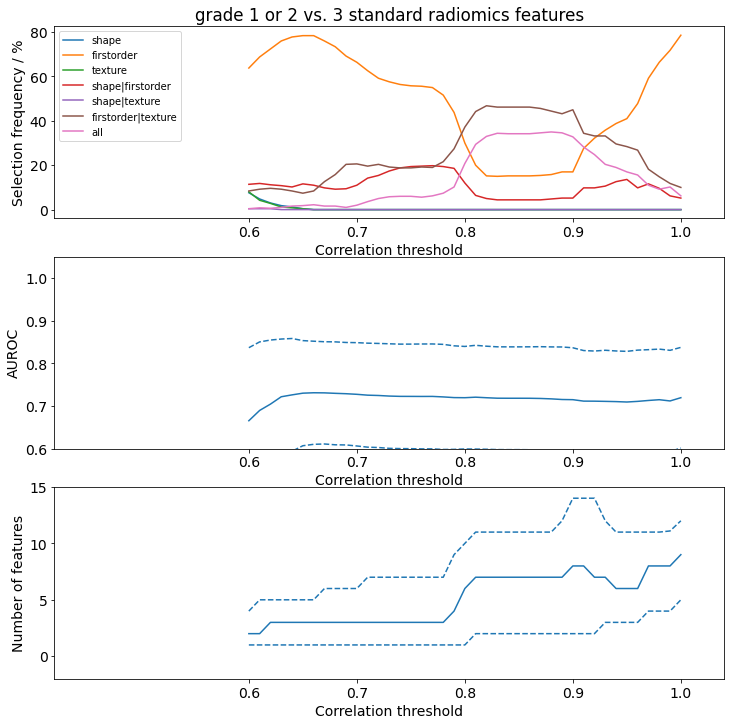

AUROC (CV) = 0.7193

Feature group = all



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,92.800,-1.388
lesion_original_glszm_ZonePercentage,45.800,0.091
lesion_original_gldm_SmallDependenceLowGrayLevelEmphasis,45.200,-0.367
lesion_original_glszm_LargeAreaHighGrayLevelEmphasis_log,44.800,-0.563
lesion_original_firstorder_InterquartileRange,44.000,
lesion_original_ngtdm_Strength_log,41.000,0.061
lesion_original_shape_Flatness,32.800,-0.230
lesion_original_firstorder_Maximum,28.600,
lesion_original_shape_Sphericity,27.400,0.191
lesion_original_firstorder_Skewness,27.000,


In [20]:
plotResultExperiments(resultStandardGrade_12vs3, titleStr = 'grade 1 or 2 vs. 3 standard radiomics features')

bestCoef, pdFreq = displayOneExperiment(resultStandardGrade_12vs3, threshold=0.8)
pdFreq.style.hide_index()

### Tumour grade: 1 v.s 2 or 3
### Volume fractions and standard radiomics features

In [21]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'Grade1vs23'
featureSet = 'lesion_original|sarcomaFeature'

df['Grade1vs23'] = df['Grade'] == 1

df = df.filter(regex=featureSet + '|' + target)

# remove one of the volume fraction features as it is co-linear with the others
df.drop('lesion_sarcomaFeature_mid enhancingVolumeFraction', axis=1, inplace=True)

In [22]:
settings = {'n_splits':n_splits, 
            'n_repeats':n_repeats,
            'thresholds':thresholds,
            'penalty':penalty
           }

quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_VolumeFractions_Grade1vs23.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

    if saveOutputs:
        with open(quickLoadFile, 'wb') as handle:
            pickle.dump(result, handle)

resultVolumeFractionGrade_1vs23 = copy.deepcopy(result)

del result
    

Threshold = 0.6
all
AUROC = 0.809 ± 0.1532

Threshold = 0.61
all
AUROC = 0.808 ± 0.1535

Threshold = 0.62
all
AUROC = 0.807 ± 0.153

Threshold = 0.63
all
AUROC = 0.806 ± 0.1537

Threshold = 0.64
all
AUROC = 0.806 ± 0.1536

Threshold = 0.65
all
AUROC = 0.806 ± 0.1535

Threshold = 0.66
all
AUROC = 0.806 ± 0.1539

Threshold = 0.67
all
AUROC = 0.805 ± 0.1537

Threshold = 0.68
VolumeFraction|firstorder
AUROC = 0.806 ± 0.1525

Threshold = 0.69
VolumeFraction|firstorder
AUROC = 0.805 ± 0.1537

Threshold = 0.7
VolumeFraction|firstorder
AUROC = 0.803 ± 0.1534

Threshold = 0.71
VolumeFraction|firstorder
AUROC = 0.804 ± 0.153

Threshold = 0.72
all
AUROC = 0.805 ± 0.1544

Threshold = 0.73
all
AUROC = 0.813 ± 0.1574

Threshold = 0.74
firstorder|texture
AUROC = 0.83 ± 0.1497

Threshold = 0.75
firstorder|texture
AUROC = 0.843 ± 0.1435

Threshold = 0.76
firstorder|texture
AUROC = 0.849 ± 0.1371

Threshold = 0.77
firstorder|texture
AUROC = 0.851 ± 0.1367

Threshold = 0.78
firstorder|texture
AUROC = 0.8

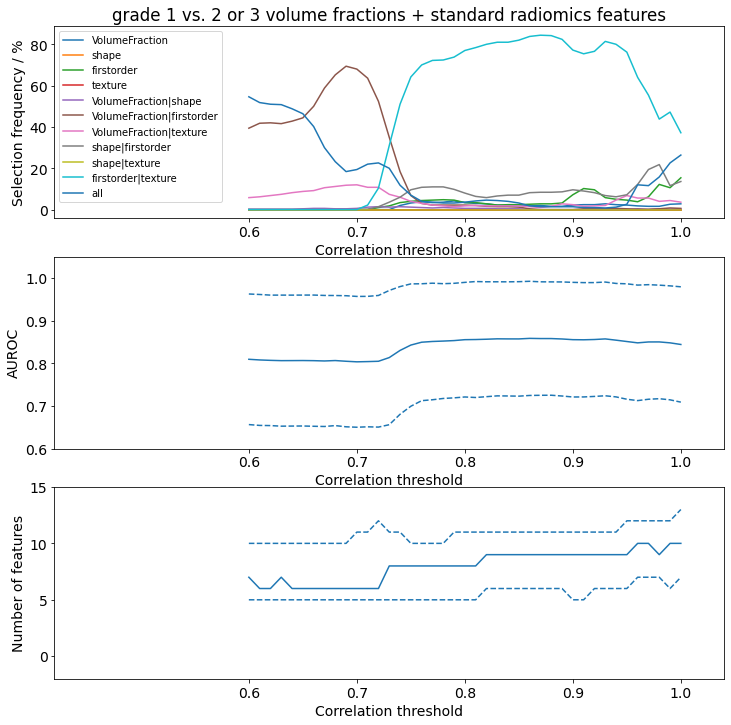

AUROC (CV) = 0.85541

Feature group = firstorder|texture



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,88.800,-1.766
lesion_original_gldm_DependenceNonUniformityNormalized_log,82.200,-0.411
lesion_original_firstorder_RootMeanSquared,80.800,0.132
lesion_original_ngtdm_Strength_log,74.600,0.288
lesion_original_glszm_ZonePercentage,66.600,0.191
lesion_original_firstorder_Skewness,64.600,0.049
lesion_original_firstorder_Kurtosis_log,55.200,0.066
lesion_original_glszm_LargeAreaHighGrayLevelEmphasis_log,45.400,-0.282
lesion_original_firstorder_InterquartileRange,44.600,
lesion_original_ngtdm_Contrast,38.000,


In [23]:
plotResultExperiments(resultVolumeFractionGrade_1vs23, titleStr = 'grade 1 vs. 2 or 3 volume fractions + standard radiomics features')

bestCoef, pdFreq = displayOneExperiment(resultVolumeFractionGrade_1vs23, threshold=0.8)
pdFreq.style.hide_index()

### Tumour grade: 1 or 2 v.s 3
### Volume fractions + standard radiomics features 

In [24]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)

target = 'Grade12vs3'
featureSet = 'lesion_original|sarcomaFeature'

df[target] = df['Grade'] != 3

df = df.filter(regex=featureSet + '|' + target)

# remove one of the volume fraction features as it is co-linear with the others
df.drop('lesion_sarcomaFeature_mid enhancingVolumeFraction', axis=1, inplace=True)

In [25]:
settings = {'n_splits':n_splits, 
            'n_repeats':n_repeats,
            'thresholds':thresholds,
            'penalty':penalty
           }

quickLoadFile = os.path.join(outputFolder, 'LR_GroupSelection_VolumeFractions_Grade12vs3.pickle')

if os.path.exists(quickLoadFile):
    with open(quickLoadFile, 'rb') as handle:
        result = pickle.load(handle)
else:
    result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

    if saveOutputs:
        with open(quickLoadFile, 'wb') as handle:
            pickle.dump(result, handle)

resultVolumeFractionGrade_12vs3 = copy.deepcopy(result)

del result
    

Threshold = 0.6
VolumeFraction|firstorder
AUROC = 0.689 ± 0.1222

Threshold = 0.61
VolumeFraction|firstorder
AUROC = 0.689 ± 0.1206

Threshold = 0.62
VolumeFraction|firstorder
AUROC = 0.69 ± 0.1204

Threshold = 0.63
VolumeFraction|firstorder
AUROC = 0.689 ± 0.1208

Threshold = 0.64
VolumeFraction|firstorder
AUROC = 0.689 ± 0.1207

Threshold = 0.65
VolumeFraction|firstorder
AUROC = 0.689 ± 0.1207

Threshold = 0.66
VolumeFraction|firstorder
AUROC = 0.689 ± 0.1208

Threshold = 0.67
VolumeFraction|firstorder
AUROC = 0.689 ± 0.1208

Threshold = 0.68
VolumeFraction|firstorder
AUROC = 0.689 ± 0.1203

Threshold = 0.69
VolumeFraction|firstorder
AUROC = 0.688 ± 0.1214

Threshold = 0.7
VolumeFraction|firstorder
AUROC = 0.687 ± 0.1195

Threshold = 0.71
VolumeFraction|firstorder
AUROC = 0.684 ± 0.119

Threshold = 0.72
VolumeFraction|firstorder
AUROC = 0.685 ± 0.1194

Threshold = 0.73
VolumeFraction|firstorder
AUROC = 0.69 ± 0.1217

Threshold = 0.74
VolumeFraction|firstorder
AUROC = 0.697 ± 0.1247



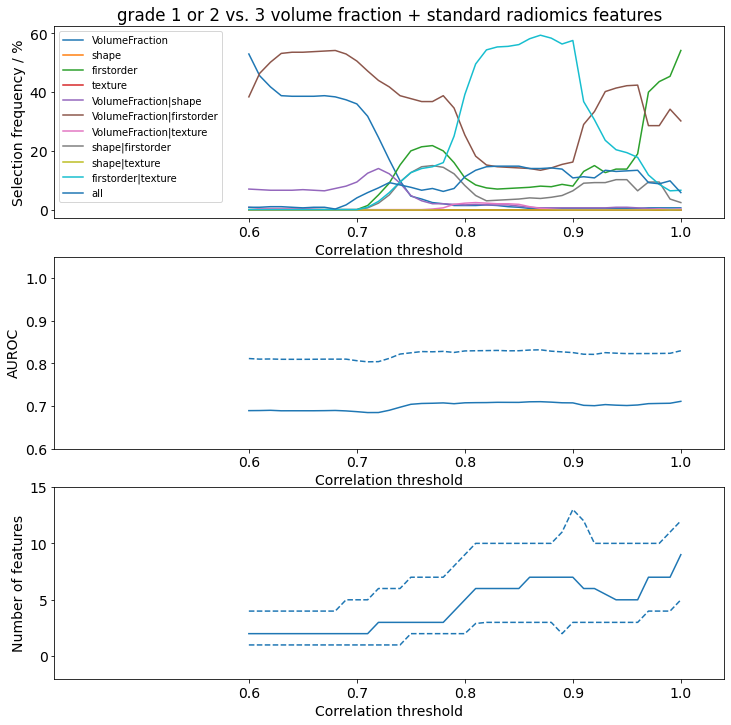

AUROC (CV) = 0.70732

Feature group = firstorder|texture



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,91.000,-1.388
lesion_original_firstorder_InterquartileRange,54.800,-0.016
lesion_sarcomaFeature_high enhancingVolumeFraction,41.800,
lesion_original_glszm_LargeAreaHighGrayLevelEmphasis_log,41.600,-0.551
lesion_original_glszm_ZonePercentage,40.200,0.071
lesion_original_ngtdm_Strength_log,37.400,0.061
lesion_original_gldm_SmallDependenceLowGrayLevelEmphasis,34.400,-0.319
lesion_original_firstorder_Skewness,22.400,
lesion_original_firstorder_RootMeanSquared,21.600,
lesion_original_shape_Flatness,20.200,


In [26]:
plotResultExperiments(resultVolumeFractionGrade_12vs3, titleStr = 'grade 1 or 2 vs. 3 volume fraction + standard radiomics features')

bestCoef, pdFreq = displayOneExperiment(resultVolumeFractionGrade_12vs3, threshold=0.8)
pdFreq.style.hide_index()

## Save this notebook once it is completed

In [27]:
from IPython.display import display, Javascript
import time

# save current state of notebook and wait a bit as the actual save happens with a short delay
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(10)

# copy notebook to output folder
if saveOutputs:
    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection.ipynb'))

<IPython.core.display.Javascript object>